In [2]:
!pip install mlflow

  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
   ---------------------------------------- 0.0/28.2 MB ? eta -:--:--
   ---------------------------------------- 0.1/28.2 MB 1.9 MB/s eta 0:00:15
   ---------------------------------------- 0.2/28.2 MB 2.1 MB/s eta 0:00:14
   ---------------------------------------- 0.3/28.2 MB 2.2 MB/s eta 0:00:13
    --------------------------------------- 0.5/28.2 MB 2.9 MB/s eta 0:00:10
   - -------------------------------------- 0.8/28.2 MB 3.7 MB/s eta 0:00:08
   - -------------------------------------- 1.3/28.2 MB 5.0 MB/s eta 0:00:06
   -- ------------------------------------- 1.6/28.2 MB 5.8 MB/s eta 0:00:05
   -- ------------------------------------- 1.6/28.2 MB 5.8 MB/s eta 0:00:05
   -- ------------------------------------- 1.6/28.2 MB 5.8 MB/s eta 0:00:05
   -- ------------------------------------- 1.6/28.2 MB 5.8 MB/s eta 0:00:05
   -- ------------------------------------- 1.6/28.2 MB 5.8 MB/s eta 0:00:05
   -----

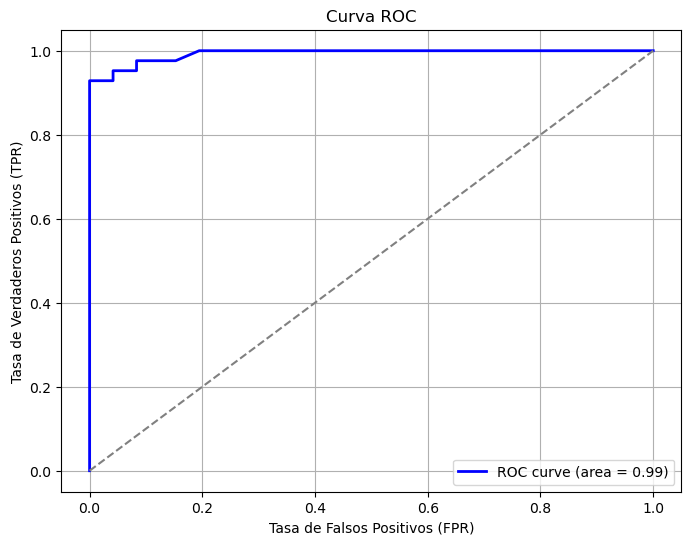

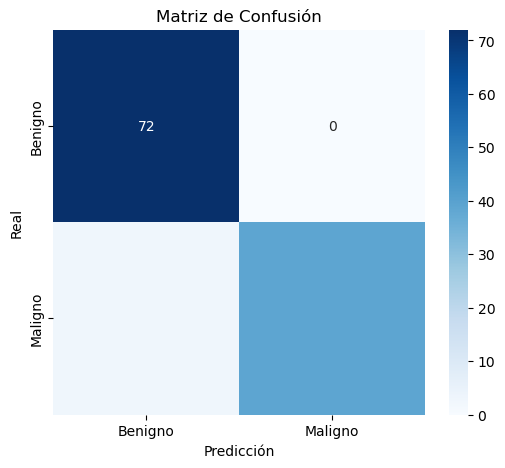

2025/03/22 23:40:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Precisión del modelo: 0.97
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn

# Cargar el archivo
file_path = r"C:\Users\jorge\OneDrive\Documentos\MCD-JORGE SANDOVAL ROSAS\2do Semestre\Programación II\Challenges\Challenge 1\breast-cancer-wisconsin.data.csv"

df = pd.read_csv(file_path)

# Mostrar las primeras filas del archivo para analizar su estructura
df.head()

# Eliminar columnas innecesarias
df = df.drop(columns=["id", "Unnamed: 32"])

# Codificar la variable objetivo (M = 1, B = 0)
df["diagnosis"] = LabelEncoder().fit_transform(df["diagnosis"])

# Separar características y variable objetivo
X = df.drop(columns=["diagnosis"])
y = df["diagnosis"]

# Normalizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir en conjuntos de entrenamiento y prueba (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Iniciar un experimento en MLflow
mlflow.set_experiment("Breast Cancer Wisconsin")

with mlflow.start_run():
    # Entrenar un modelo RandomForest
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Evaluar el modelo
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Registrar métricas
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_text(report, "classification_report.txt")

    # Calcular la curva ROC
    y_probs = model.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva (Maligno)
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Graficar la curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Línea de referencia
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()  # Muestra la imagen
    plt.savefig(r"C:\Users\jorge\OneDrive\Documentos\roc_curve.png")
    plt.close()

    # Registrar la curva ROC como una imagen
    mlflow.log_artifact("roc_curve.png")

    # Calcular y mostrar la matriz de confusión
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benigno', 'Maligno'], yticklabels=['Benigno', 'Maligno'])
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión')
    plt.show()  # Muestra la imagen
    plt.savefig(r"C:\Users\jorge\OneDrive\Documentos\confusion_matrix.png")
    plt.close()
    # Registrar la matriz de confusión como una imagen
    mlflow.log_artifact("confusion_matrix.png")

    # Registrar el modelo
    mlflow.sklearn.log_model(model, "random_forest_model")

    # Imprimir resultados
    print(f'Precisión del modelo: {accuracy:.2f}')
    print('Reporte de Clasificación:')
    print(report)